In [1]:
import sys
import os
sys.path.append('../../../')
import numpy as np
from sklearn.manifold import TSNE
import torch
from tifffile import imread
from tqdm import tqdm
from matplotlib import pyplot as plt
from glob import glob
import tifffile as tiff

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
patch_size = 64
centre_size = 4
n_channel = 32
hierarchy_level = 1
limit = 400

In [3]:
def load_model(dir):
    model = torch.load(dir+'Contrastive_MAE_best_vae.net')
    return model

In [4]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [5]:
def get_mean_centre(x, i):
    if i == 3:
        return x[i][0].cpu().numpy().reshape(n_channel,-1).mean(-1)
    elif i == 4:
        return x[i][0].cpu().numpy().reshape(n_channel,-1).mean(-1)
    else:
        lower_bound = 2**(hierarchy_level-1-i)-int(centre_size/2)
        upper_bound = 2**(hierarchy_level-1-i)+int(centre_size/2)
        return x[i][0].cpu().numpy()[:,lower_bound:upper_bound,lower_bound:upper_bound].reshape(n_channel,-1).mean(-1)

In [6]:
def get_mus(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred=True
    model.eval()
    model.to(device)
    z = z.to(device=device, dtype=torch.float)
    z = z.reshape(1,1,patch_size,patch_size)
    with torch.no_grad():
            sample = model(z, z, model_layers=[0,1,2,3,4,5])
            mu = sample['mu']
            for i in range(hierarchy_level):
                data[i*n_channel:(i+1)*n_channel] = get_mean_centre(mu, i)
            data = data.T.reshape(-1,n_features)
    return data

In [7]:
def load_data(dir):
    return imread(dir)

In [8]:
# model_dir = "/group/jug/Sheida/HDN_models/27022024/Contrastive_cosine/model/"
model_dir = "/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/Contrastive/model/"
data_dir = "/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/"
model = load_model(model_dir)
# model.load_state_dict(torch.load(model_dir+'scheduled_weight_40.net'))

In [9]:
golgi = get_normalized_tensor(load_data(data_dir+'golgi/*.tif'), model, device)
mitochondria = get_normalized_tensor(load_data(data_dir+'mitochondria/*.tif'), model, device)
granule = get_normalized_tensor(load_data(data_dir+'granules/*.tif'), model, device)
class_type = [golgi, mitochondria, granule]

In [10]:
mu = []
mus = []    
for class_t in range(len(class_type)):
    for i in tqdm(range(len(class_type[class_t]))):
        mu.append(get_mus(model,class_type[class_t][i]))
    mus.append(mu)
    mu = []


  0%|          | 0/738 [00:00<?, ?it/s]/tmp/ipykernel_36807/1948420821.py:9: RuntimeWarning: Mean of empty slice.
  return x[i][0].cpu().numpy()[:,lower_bound:upper_bound,lower_bound:upper_bound].reshape(n_channel,-1).mean(-1)
/home/sheida.rahnamai/miniconda3/envs/maester/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 1050/1050 [00:08<00:00, 118.95it/s]


In [12]:
for i in range(len(mus)):
    mus[i] = np.asarray(mus[i]).reshape(-1,32)
np.save(model_dir+'mu_golgi.npy', mus[0])
np.save(model_dir+'mu_mitochondria.npy', mus[1])
np.save(model_dir+'mu_granule.npy', mus[2])

In [12]:
def save_plot(dir):
    
    # model.load_state_dict(torch.load(dir))
    # mu = []
    mus = np.array([])
    # for class_t in range(len(class_type)):
    #     for i in tqdm(range(len(class_type[class_t]))):
    #         mu.append(get_mus(model,class_type[class_t][i]))
    #     mus.append(mu)
    #     mu = []
    # for i in range(len(mus)):
    #     mus[i] = np.asarray(mus[i]).reshape(-1,160)
    # np.save(model_dir+'mu_golgi.npy', mus[0])
    # np.save(model_dir+'mu_mitochondria.npy', mus[1])
    # np.save(model_dir+'mu_granule.npy', mus[2])
    mu_golgi = np.load(model_dir+'mu_golgi.npy')[:1000]
    mu_mitochondria = np.load(model_dir+'mu_mitochondria.npy')[:1000]
    mu_granule = np.load(model_dir+'mu_granule.npy')[:1000]
    mus = np.append(mus, mu_golgi).reshape(-1, 160)
    mus = np.append(mus, mu_mitochondria).reshape(-1,160)
    mus = np.append(mus, mu_granule).reshape(-1,160)
    X_embedded = []
    # for i in tqdm(range(len(mus))):    
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', metric='cosine', n_iter= 10000, n_iter_without_progress=500, perplexity=dir).fit_transform(mus)
    fig, ax = plt.subplots()
    # fig = plt.figure()
    # ax = fig.add_subplot(projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(10)

    ax.scatter(X_embedded[:1000].T[0], X_embedded[:1000].T[1], c='orange', s=20, label='Golgi', alpha=1, edgecolors='none')
    ax.scatter(X_embedded[1000:2000].T[0], X_embedded[1000:2000].T[1], c='blue', s=20, label='Mitochondria', alpha=1, edgecolors='none')
    ax.scatter(X_embedded[2000:].T[0], X_embedded[2000:].T[1], c='green', s=20, label='Granule', alpha=1, edgecolors='none')


    ax.legend()
    ax.grid(True)
    plt.show()
    # plt.savefig(dir[:92]+'/plots/'+dir[92:-4]+'.png')
    # plt.savefig(model_dir+'checkpoints/plots/'+str(dir)+'.png')

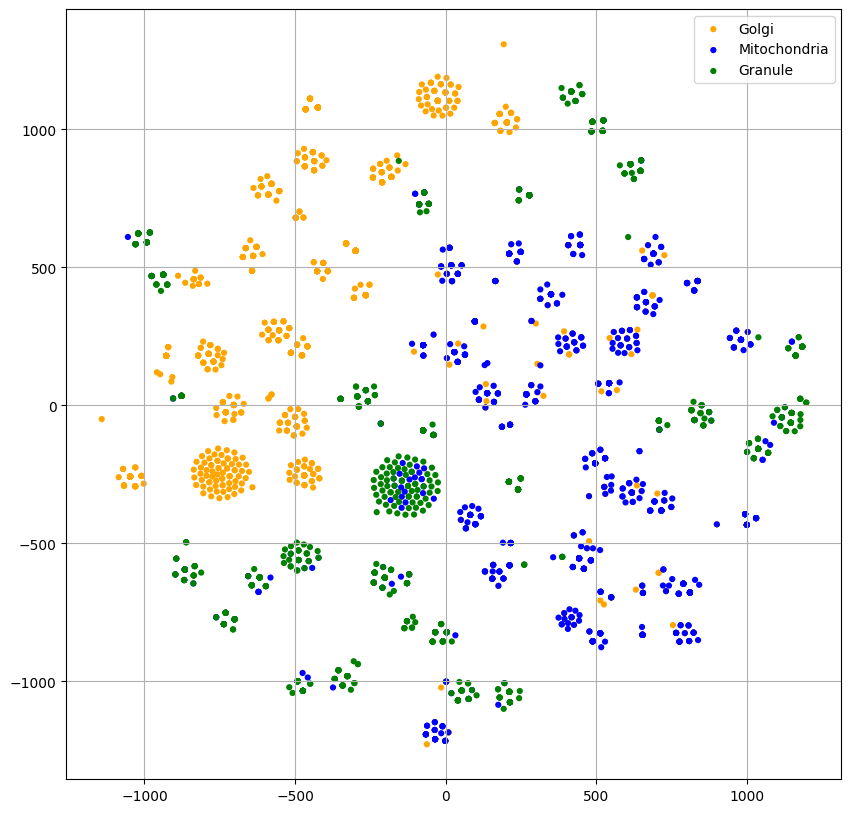

In [13]:
save_plot(50)

In [ ]:
paths = sorted(glob(model_dir+'checkpoints/*.net'), key=lambda x: int(x[92:-4]))
for path in paths:
    print(path)
    save_plot(path)